In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [6]:
# 데이터 불러오기
df = pd.read_csv('AAME.csv') 
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.drop(columns = ['Adj Close', 'Volume'])
df

,Date,Open,High,Low,Close
0,1980-03-17,0.00,4.05,3.85,3.85
1,1980-03-18,0.00,4.00,3.80,3.80
2,1980-03-19,0.00,4.05,3.85,3.85
3,1980-03-20,0.00,4.00,3.80,3.80
4,1980-03-21,0.00,3.95,3.75,3.75
...,...,...,...,...,...
10093,2020-03-26,2.29,2.29,2.08,2.28
10094,2020-03-27,2.25,2.25,2.21,2.25
10095,2020-03-30,2.25,2.25,2.13,2.13
10096,2020-03-31,2.11,2.11,2.11,2.11


In [7]:
# 'Close' 열만 정규화
close_data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_data)

In [8]:
# 시퀀스 생성 함수
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [9]:
# 윈도우 크기 및 데이터 분할
window_size = 10
split = int(len(scaled_close) * 0.8)

train_data = scaled_close[:split]
test_data = scaled_close[split - window_size:]

X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [ ]:
# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape = (window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data = (X_test, y_test))

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059 - val_loss: 7.9443e-05
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9100e-04 - val_loss: 9.6578e-05
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8727e-04 - val_loss: 8.2838e-05
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7249e-04 - val_loss: 1.0124e-04
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7982e-04 - val_loss: 6.6171e-05
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6037e-04 - val_loss: 7.0638e-05
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6229e-04 - val_loss: 9.8257e-05
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3744e-04 - val_loss: 1.1506e-04
Epoch 9/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2676e-04 - val_loss: 9.8645e-05
Epoch 10/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4564e-04 - val_loss: 8.3170e-05


In [12]:
# 예측 및 복원
predicted = model.predict(X_test)
predicted_rescaled = scaler.inverse_transform(predicted)
y_test_rescaled = scaler.inverse_transform(y_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [13]:
# RMSE 평가
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_rescaled))
print("Test RMSE:", rmse)

Test RMSE: 0.14010254779993853


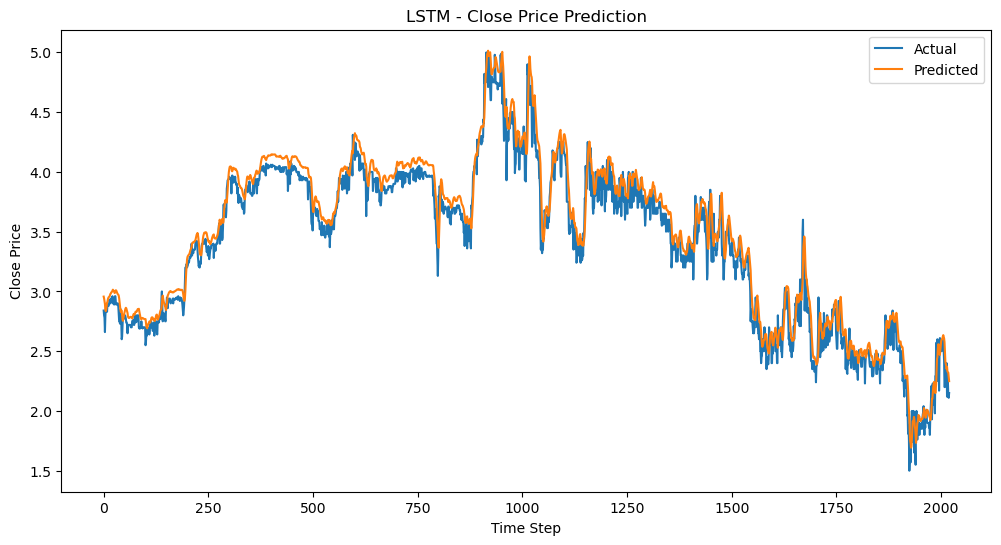

In [ ]:
# 결과 시각화
plt.figure(figsize = (12,6))
plt.plot(y_test_rescaled, label = 'Actual')
plt.plot(predicted_rescaled, label = 'Predicted')
plt.legend()
plt.title('LSTM - Close Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()